# # Sarcasm Detection Notebook (Arabic + English)
# This notebook demonstrates end-to-end training of a bilingual Bi-LSTM with attention for sarcasm detection.
# It covers data loading, normalization, vocabulary building, dataset creation, embedding setup, model definition, training, and evaluation.


#### Cell 1: Imports & Setup

In [138]:
import numpy as np
import pandas as pd
import re
import html
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import random
from itertools import chain
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from gensim.models import KeyedVectors
import pickle
# Arabic segmentation library
from camel_tools.tokenizers.word import simple_word_tokenize

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohammedbasem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Cell 2: Data Loading & Normalization
# Load Arabic CSV and English JSON-lines, normalize text, and merge datasets.


In [139]:
# Arabic dataset
df_ar = pd.read_csv('/Users/mohammedbasem/Desktop/deep learning project /data/training_data.csv')
candidates = [c for c in df_ar.columns if any(k in c.lower() for k in ('text','tweet','headline','post'))]
arabic_text_col = candidates[0] if candidates else df_ar.columns[0]

def normalize_arabic(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[A-Za-z]+', '', text)
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = re.sub(r'ـ+', '', text)
    text = re.sub(r'[إأآ]', 'ا', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    return re.sub(r"\s{2,}", " ", text).strip()

df_ar['text_norm'] = df_ar[arabic_text_col].astype(str).apply(normalize_arabic)
df_ar['sarcasm']  = df_ar['sarcasm']  # ensure label column

# English dataset
records = []
with open('/Users/mohammedbasem/Desktop/deep learning project /data/Sarcasm_Headlines_Dataset.json','r',encoding='utf-8') as f:
    for line in f:
        records.append(json.loads(line))
df_en = pd.DataFrame(records)
df_en.rename(columns={'is_sarcastic':'sarcasm'}, inplace=True)

def normalize_english(text):
    text = html.unescape(text).lower()
    contractions = {"isn't":"is not","aren't":"are not","don't":"do not","can't":"cannot","won't":"will not","it's":"it is"}
    for contr, full in contractions.items():
        text = re.sub(rf"\b{contr}\b", full, text)
    text = re.sub(r"[\r\n\t]+", " ", text)
    return re.sub(r"\s{2,}", " ", text).strip()

df_en['text_norm'] = df_en['headline'].astype(str).apply(normalize_english)
df_en['sarcasm']  = df_en['sarcasm']

# Add language tags and concatenate
df_ar['language'] = 'arabic'
df_en['language'] = 'english'
df_all = pd.concat([df_ar[['text_norm','sarcasm','language']],
                    df_en[['text_norm','sarcasm','language']]],
                   ignore_index=True)


In [167]:
df_en.shape

(26709, 6)

In [168]:
df_ar.shape

(12548, 7)

### Cell 3: Exploratory Data Analysis
# Compute sequence lengths and plot distributions for both languages.


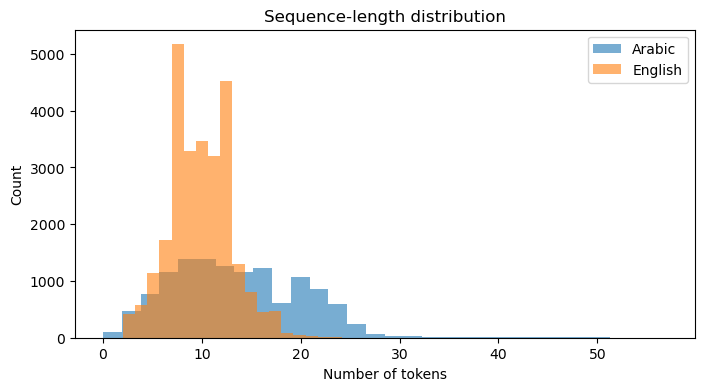

→ max_seq_len = 24


In [140]:
df_ar['length'] = df_ar['text_norm'].str.split().apply(len)
df_en['length'] = df_en['text_norm'].str.split().apply(len)

plt.figure(figsize=(8,4))
plt.hist(df_ar['length'], bins=30, alpha=0.6, label='Arabic')
plt.hist(df_en['length'], bins=30, alpha=0.6, label='English')
plt.legend()
plt.xlabel('Number of tokens')
plt.ylabel('Count')
plt.title('Sequence-length distribution')
plt.show()

# Determine max_seq_len at 95th percentile
max_seq_len = max(int(np.percentile(df_ar['length'],95)), int(np.percentile(df_en['length'],95)))
print(f"→ max_seq_len = {max_seq_len}")

### Cell 4: Vocabulary Building
# Tokenize texts by language, count tokens, and build a shared vocabulary of top 25k tokens.


In [141]:
lang2id = {'arabic':0, 'english':1}
from collections import Counter
counter = Counter()

def tokenize(text, language):
    return simple_word_tokenize(text) if language=='arabic' else text.split()

for txt, lang in zip(df_all['text_norm'], df_all['language']):
    counter.update(tokenize(txt, lang))

most_common = [tok for tok,_ in counter.most_common(25000)]
itos = ['<PAD>','<UNK>'] + most_common
stoi = {tok:i for i,tok in enumerate(itos)}
vocab_size = len(itos)

# Persist vocab
with open('vocab.pkl','wb') as f:
    pickle.dump((stoi, itos), f)
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 25002


### Cell 5: Dataset & DataLoader
# Encode texts to ID sequences, pad/truncate, split into train/val/test, and create language-balanced DataLoaders.


In [142]:
def encode_and_pad(text, lang, stoi, max_len):
    tokens = tokenize(text, lang)[:max_len]
    ids = [stoi.get(tok, stoi['<UNK>']) for tok in tokens]
    ids += [stoi['<PAD>']] * (max_len - len(ids))
    return ids

# Apply encoding
inputs = []
for _, row in df_all.iterrows():
    inputs.append(encode_and_pad(row['text_norm'], row['language'], stoi, max_seq_len))
df_all['input_ids'] = inputs

# Split
train_df, tmp_df = train_test_split(df_all, test_size=0.3, stratify=df_all['sarcasm'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['sarcasm'], random_state=42)
print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")

# Dataset class
class SarcasmDataset(Dataset):
    def __init__(self, df):
        self.ids   = df['input_ids'].tolist()
        self.labels= df['sarcasm'].astype(float).tolist()
        self.langs = df['language'].map(lang2id).tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return ( torch.tensor(self.ids[idx], dtype=torch.long),
                 torch.tensor(self.langs[idx], dtype=torch.long),
                 torch.tensor(self.labels[idx], dtype=torch.float) )

train_ds = SarcasmDataset(train_df)
val_ds   = SarcasmDataset(val_df)
test_ds  = SarcasmDataset(test_df)

# Language-balanced sampler
counts = Counter(train_df['language'])
weights = {lang:1/count for lang,count in counts.items()}
sample_weights = [weights[lang] for lang in train_df['language']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

Train/Val/Test sizes: 27479/5889/5889


### Cell 6: MUSE-Aligned Embedding Matrix
# build the embedding matrix.


In [143]:
# Randomly initialized embedding matrix
emb_dim = 300
emb_matrix = np.random.normal(0.0, 0.6, (vocab_size, emb_dim)).astype(np.float32)
emb_matrix_tensor = torch.from_numpy(emb_matrix)

neg = (train_df['sarcasm']==0).sum()
pos = (train_df['sarcasm']==1).sum()
pos_weight = torch.tensor(neg/pos, dtype=torch.float, device=device)


### Cell 7: Model Definition
# Bi-LSTM with attention, trainable embeddings, intermediate dense layer, dropout=0.5.


In [144]:

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size*2, hidden_size*2)
        self.v    = nn.Parameter(torch.rand(hidden_size*2))
    def forward(self, x):
        energy = torch.tanh(self.attn(x)).transpose(1,2)
        v = self.v.repeat(x.size(0),1).unsqueeze(1)
        scores = torch.bmm(v, energy).squeeze(1)
        weights = torch.softmax(scores, dim=1)
        return torch.bmm(weights.unsqueeze(1), x).squeeze(1)

class SarcasmDetector(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, dropout=0.5):
        super().__init__()
        self.embedding   = nn.Embedding.from_pretrained(emb_matrix_tensor, freeze=False, padding_idx=stoi['<PAD>'])
        self.emb_dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_size)
        self.fc1  = nn.Linear(hidden_size*2, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2  = nn.Linear(hidden_size, 1)
    def forward(self, input_ids, lang_id=None):
        emb = self.emb_dropout(self.embedding(input_ids))
        x, _ = self.lstm(emb)
        a    = self.attn(x)
        h    = self.dropout(F.relu(self.fc1(a)))
        return self.fc2(h).squeeze(1)

hidden_size = 128
model = SarcasmDetector(vocab_size, emb_dim, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

### Cell 8: Training & Evaluation Loops
# Functions for one training epoch and one evaluation epoch, with synonym augmentation and gradient clipping.


In [145]:
def synonym_augment(input_ids, aug_prob=0.2, drop_prob=0.1):
    tokens = [itos[idx.item()] for idx in input_ids]
    new_tokens = []
    for tok in tokens:
        if random.random() < drop_prob:
            continue  # simulate forgetting
        elif random.random() < aug_prob:
            syns = wordnet.synsets(tok)
            lemmas = set(chain.from_iterable([s.lemma_names() for s in syns]))
            lemmas.discard(tok)
            new_tokens.append(random.choice(list(lemmas)) if lemmas else tok)
        else:
            new_tokens.append(tok)
    if not new_tokens:  # avoid empty
        new_tokens = ['<PAD>']
    return torch.tensor([stoi.get(t, stoi['<UNK>']) for t in new_tokens[:max_seq_len] + ['<PAD>'] * (max_seq_len - len(new_tokens))], dtype=torch.long, device=input_ids.device)


def train_epoch(loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for ids, langs, labels in loader:
        ids, labels = ids.to(device), labels.to(device).float()
        aug_ids = torch.stack([synonym_augment(seq) for seq in ids])

        optimizer.zero_grad()
        logits = model(aug_ids).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        preds = (torch.sigmoid(logits) >= 0.35).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy



def eval_epoch(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for ids, langs, labels in loader:
            ids, labels = ids.to(device), labels.to(device).float()
            logits = model(ids).view(-1)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.35).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(probs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    f1 = f1_score(all_labels, (np.array(all_probs) >= 0.35).astype(int))  
    return avg_loss, f1, accuracy, all_probs, all_labels


### Cell 9: Run Training Loop
# Train for up to 10 epochs with early stopping on validation F1.


In [146]:
# Training hyperparameters
num_epochs = 30
patience   = 5

# Early-stopping & best-model tracking
best_f1    = 0.0
no_improve = 0
# ── INITIALIZE METRIC LISTS ─────────────────────────────────────────────────
train_losses     = []
val_losses       = []
train_accuracies = []
val_accuracies   = []
val_f1s          = []

# ── TRAINING LOOP ───────────────────────────────────────────────────────────
for epoch in range(1, num_epochs + 1):
    # 1) Train for one epoch
    train_loss, train_acc = train_epoch(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 2) Evaluate on validation set
    val_loss, val_f1, val_acc, _, _ = eval_epoch(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    # 3) Log progress
    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
    )

    # 4) Checkpoint on improvement
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ New best model saved with F1: {best_f1:.4f}")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("⏹️ Early stopping triggered")
            break

    # 5) Step LR scheduler
    scheduler.step()

Epoch 01 | Train Loss: 0.8594 | Train Acc: 0.3027 | Val Loss: 0.8962 | Val Acc: 0.3539 | Val F1: 0.5228
✅ New best model saved with F1: 0.5228
Epoch 02 | Train Loss: 0.7595 | Train Acc: 0.5463 | Val Loss: 0.6675 | Val Acc: 0.7022 | Val F1: 0.6654
✅ New best model saved with F1: 0.6654
Epoch 03 | Train Loss: 0.6471 | Train Acc: 0.7052 | Val Loss: 0.6027 | Val Acc: 0.7636 | Val F1: 0.7136
✅ New best model saved with F1: 0.7136
Epoch 04 | Train Loss: 0.5771 | Train Acc: 0.7477 | Val Loss: 0.5700 | Val Acc: 0.7813 | Val F1: 0.7305
✅ New best model saved with F1: 0.7305
Epoch 05 | Train Loss: 0.5317 | Train Acc: 0.7699 | Val Loss: 0.5428 | Val Acc: 0.7928 | Val F1: 0.7439
✅ New best model saved with F1: 0.7439
Epoch 06 | Train Loss: 0.4828 | Train Acc: 0.7976 | Val Loss: 0.5351 | Val Acc: 0.7988 | Val F1: 0.7509
✅ New best model saved with F1: 0.7509
Epoch 07 | Train Loss: 0.4602 | Train Acc: 0.8111 | Val Loss: 0.5267 | Val Acc: 0.7969 | Val F1: 0.7511
✅ New best model saved with F1: 0.7511

In [147]:
import numpy as np
from sklearn.metrics import f1_score

# Use the updated eval_epoch
val_loss, f1_default, val_acc, all_probs, all_labels = eval_epoch(val_loader)

# Threshold tuning
thresholds = np.arange(0.3, 0.71, 0.01)
best_f1 = 0
best_thresh = 0.5

for t in thresholds:
    preds = (np.array(all_probs) >= t).astype(int)
    f1 = f1_score(all_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"🔍 Best Threshold = {best_thresh:.2f} | F1 = {best_f1:.4f}")


🔍 Best Threshold = 0.53 | F1 = 0.7893


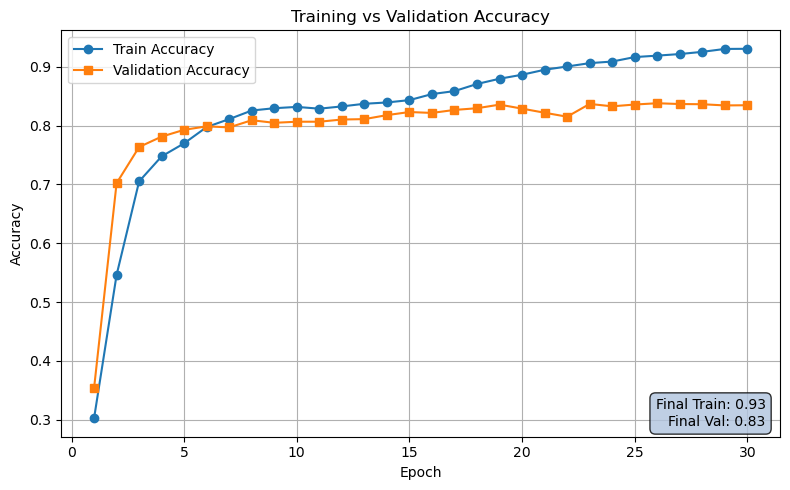

In [148]:
epochs = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(8, 5))

# Accuracy Plot
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend()
# Final accuracy values
final_train = train_accuracies[-1]
final_val = val_accuracies[-1]
final_text = f'Final Train: {final_train:.2f}\nFinal Val: {final_val:.2f}'

# Add textbox in bottom-right
plt.text(
    0.98, 0.02, final_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightsteelblue', alpha=0.8)
)

plt.tight_layout()
plt.show()


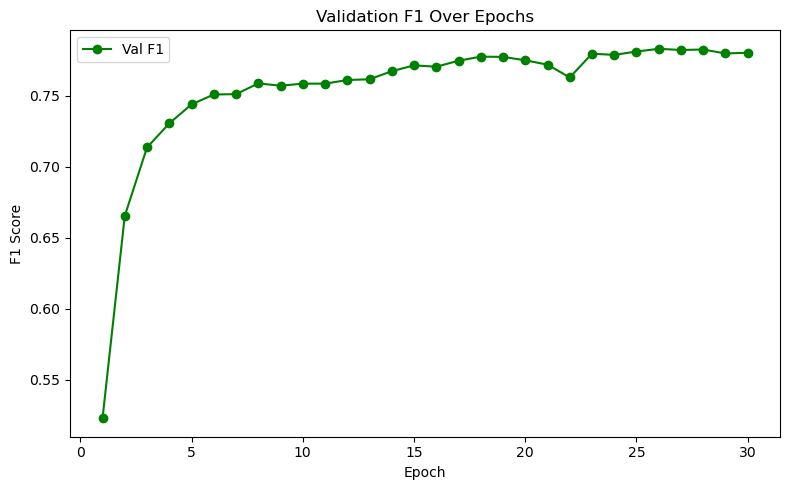

In [149]:
# F1 Score Plot
plt.figure(figsize=(8, 5))

plt.plot(epochs, val_f1s, label='Val F1', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### Cell 10: Test Evaluation
# Load best model, evaluate on test set, and display classification report.


In [150]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_f1, test_acc, test_probs, test_labels = eval_epoch(test_loader)
test_preds = (np.array(test_probs) >= 0.5).astype(int)
print(f"Test Loss: {test_loss:.4f} | Test F1: {test_f1:.4f}")
print(classification_report(test_labels, test_preds, digits=4))

Test Loss: 0.6834 | Test F1: 0.7728
              precision    recall  f1-score   support

         0.0     0.8792    0.8699    0.8745      3805
         1.0     0.7669    0.7817    0.7742      2084

    accuracy                         0.8387      5889
   macro avg     0.8230    0.8258    0.8244      5889
weighted avg     0.8394    0.8387    0.8390      5889



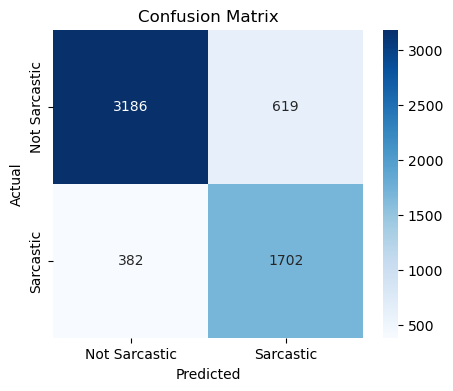

In [151]:
# === Cell: “Gather Test Predictions” ===

model.eval()
y_true = []
y_scores = []

with torch.no_grad():
    for ids, langs, labels in test_loader:
        # Move to device & cast
        ids, labels = ids.to(device), labels.to(device).float()

        # Forward pass; ensure logits is always a 1D tensor
        logits = model(ids).view(-1)                # shape: (batch_size,)

        # Convert to probabilities
        probs = torch.sigmoid(logits).cpu().numpy() # now always an array

        # Extend lists
        y_scores.extend(probs.tolist())             # safe: probs is array/list
        y_true.extend(labels.cpu().numpy().tolist())

# Apply your threshold of 0.35
threshold = 0.35
y_pred = [1 if p >= threshold else 0 for p in y_scores]

# Now y_true and y_pred are defined for downstream metrics
# === Cell: “Confusion Matrix” ===

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
labels = ['Not Sarcastic','Sarcastic']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


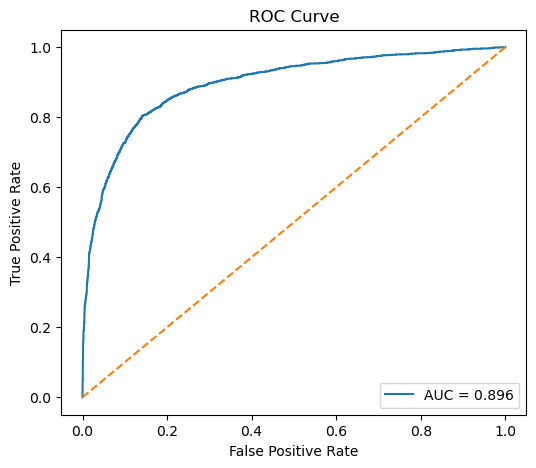

In [154]:
from sklearn.metrics import roc_curve, auc

# y_true: true labels, y_scores: model probabilities for class=1
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')  # random
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


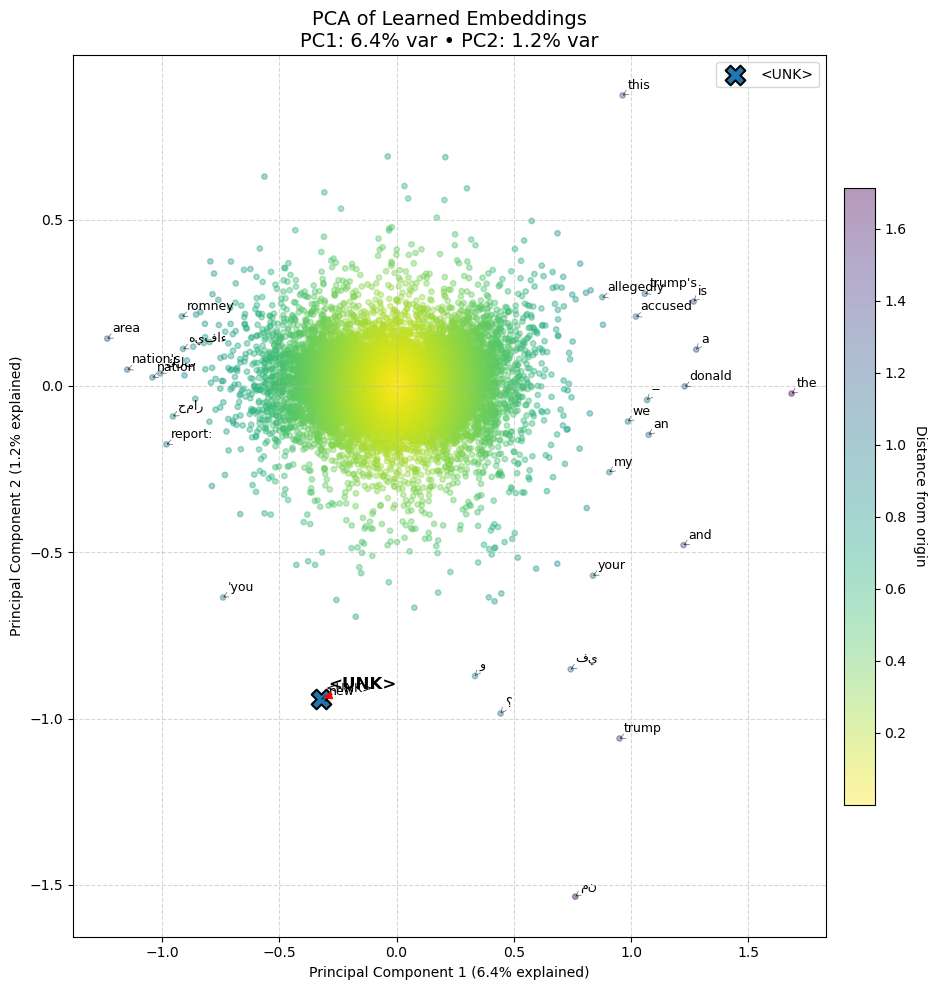

In [170]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# === Enhanced PCA Visualization for Learned Embeddings ===

# 1. Convert embedding to NumPy array
emb_np = emb_matrix  # shape: (vocab_size, emb_dim)

# 2. Subset to avoid overplotting
max_points = 20000
subset_size = min(max_points, emb_np.shape[0])
subset = emb_np[:subset_size]
labels = [itos[i] for i in range(subset_size)]

# 3. Run PCA to 2D and grab explained variance ratios
pca = PCA(n_components=2)
coords = pca.fit_transform(subset)
var1, var2 = pca.explained_variance_ratio_

# 4. Compute distance from origin (for coloring + outlier detection)
dists = np.linalg.norm(coords, axis=1)
topk = np.argsort(dists)[-30:]  # 30 farthest points

# 5. Plot all points, coloring by distance from origin
plt.figure(figsize=(10, 10))
sc = plt.scatter(
    coords[:, 0], coords[:, 1],
    c=dists, cmap='viridis_r',  # viridis_r lets the farthest (outliers) stand out
    s=15, alpha=0.4
)
cbar = plt.colorbar(sc, shrink=0.7, pad=0.02)
cbar.set_label('Distance from origin', rotation=270, labelpad=15)

# 6. Annotate the top outliers with arrows
for i in topk:
    plt.annotate(
        labels[i],
        xy=coords[i],
        xytext=(coords[i, 0] + 0.02, coords[i, 1] + 0.02),
        textcoords='data',
        arrowprops=dict(arrowstyle='->', lw=0.5, alpha=0.6),
        fontsize=9
    )

# 7. Highlight the <UNK> token if present
if '<UNK>' in labels:
    unk_idx = labels.index('<UNK>')
    x0, y0 = coords[unk_idx]
    plt.scatter(
        x0, y0, marker='X', s=200,
        edgecolor='black', linewidth=1.5,
        label='<UNK>'
    )
    plt.annotate(
        '<UNK>',
        xy=(x0, y0), xytext=(x0 + 0.03, y0 + 0.03),
        fontsize=12, fontweight='bold',
        arrowprops=dict(arrowstyle='-|>', lw=1.0, color='red')
    )

# 8. Styling and labels
plt.title('PCA of Learned Embeddings\n'
          f'PC1: {var1*100:.1f}% var • PC2: {var2*100:.1f}% var', fontsize=14)
plt.xlabel(f'Principal Component 1 ({var1*100:.1f}% explained)')
plt.ylabel(f'Principal Component 2 ({var2*100:.1f}% explained)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
